<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Obtenir-les-données" data-toc-modified-id="Obtenir-les-données-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Obtenir les données</a></span></li><li><span><a href="#Exercice-1-:-SVM-linéaires" data-toc-modified-id="Exercice-1-:-SVM-linéaires-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Exercice 1 : SVM linéaires</a></span></li><li><span><a href="#Exercice-2-:-SVM-kernélisés" data-toc-modified-id="Exercice-2-:-SVM-kernélisés-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Exercice 2 : SVM kernélisés</a></span></li><li><span><a href="#Exercice-2-:-Visualisation-de-l'entraînement" data-toc-modified-id="Exercice-2-:-Visualisation-de-l'entraînement-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Exercice 2 : Visualisation de l'entraînement</a></span></li><li><span><a href="#Exercice-3-:-Visualisation-des-modèles-RBF-et-de-l'espace-des-hyperparamètres" data-toc-modified-id="Exercice-3-:-Visualisation-des-modèles-RBF-et-de-l'espace-des-hyperparamètres-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Exercice 3 : Visualisation des modèles RBF et de l'espace des hyperparamètres</a></span></li></ul></div>

# Lab 5 : Kernelisation
Les machines à vecteurs de support sont des méthodes puissantes, mais elles nécessitent également un réglage minutieux. Nous allons explorer les noyaux SVM et les hyperparamètres sur un ensemble de données artificielles. Nous nous pencherons en particulier sur le sous-apprentissage et le surapprentissage des modèles.

In [6]:
# Auto-setup when running on Google Colab
if 'google.colab' in str(get_ipython()):
    !pip install openml

# General imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openml as oml
from matplotlib import cm

# Hide convergence warning for now
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action="ignore", category=ConvergenceWarning)

## Obtenir les données
Nous récupérons les données de Banana à partir d'OpenML : https://www.openml.org/d/1460  

In [7]:
bananas = oml.datasets.get_dataset(1460) # Banana data has OpenML ID 1460
X, y, _, _ = bananas.get_data(target=bananas.default_target_attribute, dataset_format='array');

/tmp/ipykernel_4914/3794883227.py:1: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  bananas = oml.datasets.get_dataset(1460) # Banana data has OpenML ID 1460
/tmp/ipykernel_4914/3794883227.py:2: FutureWarning: Support for `dataset_format='array'` will be removed in 0.15,start using `dataset_format='dataframe' to ensure your code will continue to work. You can use the dataframe's `to_numpy` function to continue using numpy arrays.
  X, y, _, _ = bananas.get_data(target=bananas.default_target_attribute, dataset_format='array');


Un rapide coup d'œil sur les données :

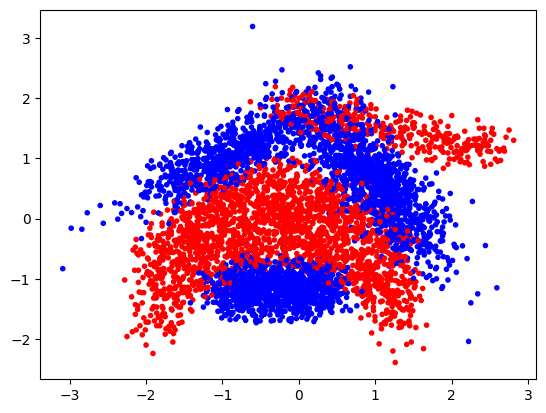

In [8]:
plt.scatter(X[:,0], X[:,1], c=y,cmap=plt.cm.bwr, marker='.');

In [9]:
# Plotting helpers. Based loosely on https://github.com/amueller/mglearn
def plot_svm_kernel(X, y, title, support_vectors, decision_function, dual_coef=None, show=True):
    """
    Visualizes the SVM model given the various outputs. It plots:
    * All the data point, color coded by class: blue or red
    * The support vectors, indicated by circling the points with a black border. 
      If the dual coefficients are known (only for kernel SVMs) if paints support vectors with high coefficients darker
    * The decision function as a blue-to-red gradient. It is white where the decision function is near 0.
    * The decision boundary as a full line, and the SVM margins (-1 and +1 values) as a dashed line
    
    Attributes:
    X -- The training data
    y -- The correct labels
    title -- The plot title
    support_vectors -- the list of the coordinates of the support vectores
    decision_function - The decision function returned by the SVM
    dual_coef -- The dual coefficients of all the support vectors (not relevant for LinearSVM)
    show -- whether to plot the figure already or not
    """
    # plot the line, the points, and the nearest vectors to the plane
    #plt.figure(fignum, figsize=(5, 5))
    plt.title(title)
    plt.scatter(X[:, 0], X[:, 1], c=y, zorder=10, cmap=plt.cm.bwr, marker='.')
    if dual_coef is not None:
        plt.scatter(support_vectors[:, 0], support_vectors[:, 1], c=dual_coef[0, :],
                    s=70, edgecolors='k', zorder=10, marker='.', cmap=plt.cm.bwr)
    else:
        plt.scatter(support_vectors[:, 0], support_vectors[:, 1], facecolors='none',
                    s=70, edgecolors='k', zorder=10, marker='.', cmap=plt.cm.bwr)
    plt.axis('tight')
    x_min, x_max = -3.5, 3.5
    y_min, y_max = -3.5, 3.5

    XX, YY = np.mgrid[x_min:x_max:300j, y_min:y_max:300j]
    Z = decision_function(np.c_[XX.ravel(), YY.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
                levels=[-1, 0, 1])
    plt.pcolormesh(XX, YY, Z, vmin=-1, vmax=1, cmap=plt.cm.bwr, alpha=0.1)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    
    plt.xticks(())
    plt.yticks(())

    if show:
        plt.show()
    
def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f"):
    """
    Visualizes the results of a grid search with two hyperparameters as a heatmap.
    Attributes:
    values -- The test scores
    xlabel -- The name of hyperparameter 1
    ylabel -- The name of hyperparameter 2
    xticklabels -- The values of hyperparameter 1
    yticklabels -- The values of hyperparameter 2
    cmap -- The matplotlib color map
    vmin -- the minimum value
    vmax -- the maximum value
    ax -- The figure axes to plot on
    fmt -- formatting of the score values
    """
    if ax is None:
        ax = plt.gca()
    # plot the mean cross-validation scores
    img = ax.pcolor(values, cmap=cmap, vmin=None, vmax=None)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel, fontsize=10)
    ax.set_ylabel(ylabel, fontsize=10)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)
    
    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(axis='x', labelsize=12, labelrotation=90)

    for p, color, value in zip(img.get_paths(), img.get_facecolors(), img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % value, color=c, ha="center", va="center", size=10)
    return img

## Exercice 1 : SVM linéaires

Tout d'abord, nous examinerons les SVM linéaires et les différents résultats qu'ils produisent. Consultez la [documentation de LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC)

Les entrées les plus importantes sont les suivantes  
* C -- L'hyperparamètre C contrôle le coût de la mauvaise classification et donc le niveau de régularisation. Des valeurs plus faibles correspondent à une plus grande régularisation
* loss - La fonction de perte, typiquement 'hinge' ou 'squared_hinge'. squared_hinge est la valeur par défaut. La hinge normale est moins stricte.
* dual - Si l'on veut résoudre le problème d'optimisation primal ou le problème dual (par défaut). Le primal est recommandé si vous avez beaucoup plus de points de données que de caractéristiques (bien que nos ensembles de données soient très petits, donc cela n'aura pas beaucoup d'importance).

Les résultats les plus importants sont les suivants :  
* la fonction de décision - La fonction utilisée pour classer un point. Dans le cas des SVM linéaires, cela correspond à l'hyperplan appris, ou $y = \mathbf{wX} + b$. Il peut être évalué en tout point, si le résultat est positif, le point est classé dans la classe positive et vice versa. 
* coef_ - Les coefficients du modèle, c'est-à-dire les poids $\mathbf{w}$.
* intercept_ - le biais $b$.

La fonction de décision permet de déterminer quels points sont des vecteurs de support et lesquels ne le sont pas : les vecteurs de support sont tous les points qui se situent à l'intérieur de la marge.
les points qui se trouvent à l'intérieur de la marge, c'est-à-dire qui ont une valeur de décision comprise entre -1 et 1, ou qui sont mal classés. Voir également les diapositives du cours.

### Exercice 1.1 : SVM linéaires
Entraînez un SVM linéaire avec C=0.001 et une loss hinge. Ensuite, utilisez la fonction de tracé `plot_svm_kernel` pour tracer les résultats. Pour cela, vous devez extraire les vecteurs de support de la fonction de décision. Vous trouverez ci-dessous une astuce au cas où vous seriez bloqué. 
Interprétez le graphique de la manière la plus détaillée possible. Vous pouvez ensuite essayer d'autres paramètres. Vous pouvez également essayer d'utiliser le problème d'optimisation primal au lieu du problème d'optimisation dual (dans ce cas, utilisez la fonction perte squared_hinge).

In [10]:
# Conseil : comment calculer les vecteurs de support à partir de la fonction de décision (à ignorer si vous voulez résoudre ce problème vous-même)
# support_vector_indices = np.where((2 * y - 1) * clf.decision_function(X) <= 1)[0]
# support_vectors = X[support_vector_indices]

# Notez que nous pouvons également calculer la fonction de décision manuellement à l'aide de la formule y = w*X
# decision_function = np.dot(X, clf.coef_[0]) + clf.intercept_[0]

## Exercice 2 : SVM kernélisés

Consultez la [documentation du SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

Il dispose de quelques entrées supplémentaires. Les plus importantes : 
* kernel - Il doit être soit 'linear', 'poly', 'rbf', 'sigmoid', ou votre noyau personnalisé.
* gamma - La largeur du kernel `rbf` (gaussien). Des valeurs plus petites signifient des noyaux plus larges. 
          Ne concerne que la sélection du kernel rbf.
* degree - Le degré du kernel polynomial. Ne concerne que la sélection du kernel poly.

Il existe également d'autres sorties qui nous facilitent la vie :  
* support_vectors_ - Le tableau des vecteurs de support
* n_support_ - Le nombre de vecteurs de support par classe
* dual_coef_ - Les coefficients des vecteurs de support (les coefficients duals)

### Exercice 2.1

Évaluez différents kernels, avec leurs paramètres hyperparamétriques par défaut.
Les résultats doivent être les scores de précision validés par 5 splits pour le kernel linéaire (lin_scores), le noyau polynomial (poly_scores) et le noyau RBF (rbf_scores). Affichez la moyenne et la variance des scores et donnez une première interprétation des performances de chaque kernel.

## Exercice 2 : Visualisation de l'entraînement
Pour mieux comprendre ce que font les différents kernels, visualisons leurs prédictions.

### Exercice 2.1
Appelez et entraînez le SVM avec des kernels linéaires, polynomiaux et RBF avec les valeurs de paramètres par défaut. Pour le noyau RBF, utilisez une valeur de coefficient de kernel (gamma) de 2.0. Tracez les résultats pour chaque kernel avec la fonction "plot_svm_kernel". Les graphiques montrent les prédictions faites pour les différents kernels. La couleur de fond indique la prédiction (bleu ou rouge). La ligne pleine montre la limite de décision, et la ligne pointillée la marge. Les points encerclés sont les vecteurs de support.

### Exercice 2.2
Interprétez les graphiques pour chaque kernel. Réfléchissez aux moyens d'améliorer les résultats.

## Exercice 3 : Visualisation des modèles RBF et de l'espace des hyperparamètres
Sélectionnez le kernel RBF et optimisez les deux hyperparamètres les plus importants (le paramètre 𝐶 et la largeur du kernel 𝛾 ).

Conseil : les valeurs de C et $\gamma$ sont généralement comprises dans [$2^{-15}..2^{15}$] sur une échelle logarithmique. 

### Exercice 3.1
Essayez d'abord 3 valeurs très différentes pour $C$ et $\gamma$ (par exemple [1e-3,1,1e3]). Pour chacune des 9 combinaisons, créez le même tracé RBF que précédemment pour comprendre ce que fait le modèle. Créez également un split train-test standard et indiquez les résultats du train et du test. Expliquez les résultats des performances. Quand l'ajustement est-il excessif ou insuffisant ? Cela se voit-il dans les prédictions ?

### Exercice 3.2
Optimisez les hyperparamètres à l'aide d'une grille de recherche, en essayant toutes les combinaisons possibles de C et de gamma. Montrez une carte de chaleur (heatmap) des résultats et indiquez les valeurs optimales des hyperparamètres. Utiliser au moins 10 valeurs pour $C$ et $\gamma$ dans [$2^{-15}..2^{15}$] sur une échelle logarithmique. Indiquer une précision avec une validation croisee de 3 splits. Nous recommandons d'utiliser [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)  de sklearn et la fonction `heatmap` définie ci-dessus. Consultez leur documentation.